In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!echo '{"username":"kushgabani","key":"b7e66dad2858a34351f0dadd9c1fb1e1"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

 98% 1.06G/1.08G [00:13<00:00, 64.9MB/s]
100% 1.08G/1.08G [00:13<00:00, 83.7MB/s]


In [4]:
!unzip /content/the-simpsons-characters-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1270.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: dataset/simpsons_dataset/simpsons_

In [5]:
%tensorflow_version 2.x
import os
import shutil
import sys
import numpy as np
import random
import copy
import time
import math
import pickle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D, TimeDistributed
from keras.optimizers import Adam
from keras import initializers , regularizers
from keras.objectives import categorical_crossentropy
from keras.utils.generic_utils import Progbar

os.chdir("./dataset/")
try:
  shutil.rmtree("./../sample_data")
  shutil.rmtree("./simpsons_dataset/simpsons_dataset")
  os.rename("./simpsons_dataset", "./characters")
  shutil.rmtree("./kaggle_simpson_testset")
except:
  pass

In [7]:
class param_config:
  def __init__(self):
    self.network = 'ResNet'

    self.verbose = True
    self.use_horizontal_flips = False
    self.use_vertical_flips = False

    self.anchor_scales = [64, 128, 256, 512]
    self.anchor_ratios = [[1, 1], [1, 2], [2, 1]]

    self.image_size = 300
    self.image_scaling_factor = 1.0
    self.image_channel_mean =[103.939, 116.779, 123.68]

    self.num_ROIs = 4
    self.RPN_stride = 16
    self.balanced_classes = False

    self.std_scaling = 4.0
    self.classifier_reg_std = [8.0, 8.0, 4.0, 4.0]

    self.rpn_overlap_max = 0.7
    self.rpn_overlap_min = 0.3

    self.classifier_overlap_max = 0.7
    self.classifier_overlap_min = 0.3

    self.class_mapping = None

    self.base_net_weights = None
    self.model_path = None
    self.record_path = None

In [8]:
def get_format_data(input_path):
  images = {}
  class_mapping = {}
  class_count = {}

  with open(input_path, "r") as annot_file:
    print("Parsing annotation files")
    for record in annot_file:
      record_split = record.strip().split(",")
      (filename, x1, y1, x2, y2, char_name) = record_split

      if char_name not in class_count:
        class_count[char_name] = 1
      else:
        class_count[char_name] += 1

      if char_name not in class_mapping:
        class_mapping[char_name] = len(class_mapping)

      if filename not in images:
        images[filename] = {}
        img = cv2.imread(filename)
        if type(img) != None:
          (rows, cols) = img.shape[:2]
          images[filename]["filepath"] = filename
          images[filename]["width"] = cols
          images[filename]["height"] = rows
          images[filename]["bboxes"] = []
          sys.stdout.write('\r'+'character_file = "' + str(images[filename]['filepath']))
          
          if np.random.randint(0, 6) > 0:
            images[filename]["imageset"] = "training_and_validation"
          else:
            images[filename]["imageset"] = "testing"

        images[filename]["bboxes"].append({
                                            'class' : char_name,
                                            'x1' : int(x1),
                                            'x2' : int(x2),
                                            'y1' : int(y1),
                                            'y2' : int(y2)
                                          })
        
    data = []
    for img_data in images:
      data.append(images[img_data])

    class_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)
    random.shuffle(data)
    return data, class_count, class_mapping

In [6]:
class ROIPoolingConvLayer(Layer):
  def __init__(self, pool_size, num_ROIs, **kwargs):
    self.dim_ordering = "tf"
    self.pool_size = pool_size
    self.num_ROIs = num_ROIs
    
    super(ROIPoolingConvLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.nb_channels = input_shape[0][3]
  
  def comput_output_shape(self, input_shape):
    return None, self.num_ROIs, self.pool_size, self.pool_size, self.nb_channels
  
  def get_config(self):
    config =  {
        'pool_size' : self.pool_size,
        'num_ROIs' : self.num_ROIs
    }
    base_config = super(ROIPoolingConvLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, x, mask = None):
    assert(len(x) == 2)
    img = x[0]
    ROIs = x[1]

    input_shape = K.shape(img)
    pooled_output = []

    for i in range(self.num_ROIs):
      x = K.cast(ROIs[0, i, 0], 'int32')
      y = K.cast(ROIs[0, i, 1], 'int32')
      w = K.cast(ROIs[0, i, 2], 'int32')
      h = K.cast(ROIs[0, i, 3], 'int32')

      rs = tf.image.resize(img[:, y : y + h, x : x + w, :], (self.pool_size, self.pool_size))
      pooled_output.append(rs)

    output = K.concatenate(pooled_output, axis = 0)
    output = K.reshape(output, (1, self.num_ROIs, self.pool_size, self.pool_size, self.nb_channels))
    output = K.permute_dimensions(output, (0, 1, 2, 3, 4))
    return output

In [9]:
class FixedBatchNormalization(Layer):
  def __init__(self, epsilon=1e-3,
               axis = -1,
               weights = None,
               beta_init = "zero",
               gamma_init = "one",
               gamma_regularizer = None,
               beta_regularizer = None, **kwargs):
    self.supports_masking = True
    self.beta_init = initializers.get(beta_init)
    self.gamma_init = initializers.get(gamma_init)
    self.epsilon = epsilon
    self.axis = axis
    self.beta_regularizer = regularizers.get(beta_regularizer)
    self.gamma_regularizer = regularizers.get(gamma_regularizer)
    self.initial_weights = weights
    super(FixedBatchNormalization, self).__init__(**kwargs)

  def build(self, input_shape):
    self.input_spec = [InputSpec(shape=input_shape)]
    shape = (input_shape[self.axis], )

    self.gamma = self.add_weight(shape = shape,
                                 initializer = self.gamma_init,
                                 regularizer = self.gamma_regularizer,
                                 name = '{}_gamma'.format(self.name),
                                 trainable = False)
    
    self.beta = self.add_weight(shape = shape,
                                initializer = self.beta_init,
                                regularizer = self.beta_regularizer,
                                name = '{}_beta'.format(self.name),
                                trainable = False)
  
    self.running_mean = self.add_weight(shape = shape,
                                        initializer = "zero",
                                        name = '{}_running_mean'.format(self.name),
                                        trainable = False)
    
    self.running_std = self.add_weight(shape = shape,
                                       initializer = "one",
                                       name = '{}_running_std'.format(self.name),
                                       trainable = False)
    
    if self.initial_weights is not None:
      self.set_weights(self.initial_weights)
      del self.initial_weights
    self.built = True

  def call(self, x, mask = None):
    assert self.built, 'Layer must be built before calling.'

    input_shape = K.int_shape(x)
    reduction_axes = list(range(len(input_shape)))
    del reduction_axes[self.axis]
    broadcast_shape = [1] * len(input_shape)
    broadcast_shape[self.axis] = input_shape[self.axis]

    if sorted(reduction_axes) == range(K.ndim(x))[:-1]:
      x_normed = K.batch_normalization(x,
                                       self.running_mean,
                                       self.running_std,
                                       self.beta,
                                       self.gamma,
                                       epsilon = self.epsilon)
    else:
      broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
      broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
      broadcast_beta = K.reshape(self.beta, broadcast_shape)
      broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
      x_normed = K.batch_normalization(x,
                                       broadcast_running_mean,
                                       broadcast_running_std,
                                       broadcast_beta,
                                       broadcast_gamma,
                                       epsilon = self.epsilon)
    return x_normed

  def get_config(self):
    config = {
                'epsilon' : self.epsilon,
                'axis' : self.axis,
                'gamma_regularizer' : self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
                'beta_regularizer' : self.beta_regularizer.get_config() if self.beta_regularizer else None
              }
    base_config = super(FixedBatchNormalization, self).get_config()
    return dict((list(base_config.items())) + list(config.items()))

In [ ]:
def identity_block(input, kernel_size, filters, level, block, trainable = True):
  f1, f2, f3 = filters
  bn_axis  = 3

  conv_nomenclature = 'res' + str(level) + block + '_branch'
  bn_nomenclature = 'bn' + str(level) + block + '_branch'

  x = Convolution2D(f1, (1, 1), name = conv_nomenclature + '2a', trainable = trainable)(input)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2a')(x)
  x = Activation('relu')(x)

  x = Convolution2D(f2, (kernel_size, kernel_size), padding = "same", name = conv_nomenclature + '2b', trainable = trainable)(x)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2b')(x)
  x = Activation('relu')(x)

  x = Convolution2D(f3, (1, 1), name = conv_nomenclature + '2c', trainable = trainable)(x)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2c')(x)
  
  x = Add()([x, input])
  x = Activation('relu')(x)
  return x

def conv_block(input, kernel_size, filters, level, block, strides = (2, 2), trainable = True):
  f1, f2, f3 = filters
  bn_axis = 3

  conv_nomenclature = 'res' + str(level) + block + '_branch'
  bn_nomenclature = 'bn' + str(level) + block + '_branch'

  x = Convolution2D(f1, (1, 1), strides = strides, name = conv_nomenclature + '2a', trainable = trainable)(input)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2a')(x)
  x = Activation('relu')(x)

  x = Convolution2D(f2, (kernel_size, kernel_size), padding = "same", name = conv_nomenclature + '2b', trainable = trainable)(x)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2b')(x)
  x = Activation('relu')(x)

  x = Convolution2D(f3, (1, 1), name = conv_nomenclature + '2c', trainable = trainable)(x)
  x = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '2c')(x)
  
  jump_shortcut = Convolution2D(f3, (1, 1), strides = strides, name = conv_nomenclature, trainable = trainable)(input)
  jump_shortcut = FixedBatchNormalization(axis = bn_axis, name = bn_nomenclature + '1')(jump_shortcut)

  x = Add()([x, jump_shortcut])
  x = Activation('relu')(x)
  return x


def ResNet(input = None, trainable = False):
  input_shape = (None, None, 3)
  if input is None:
    img_input = Input(shape = input_shape)
  else:
    if not K.is_keras_tensor(input):
      img_input = Input(tensor = input, shape = input_shape)
    else:
      img_input = input

  bn_axis = 3

  x = ZeroPadding2D((3, 3))(img_input)
  x = Convolution2D(64, (7, 7), strides = (2, 2), name = 'conv1', trainable = trainable)(x)
  x = FixedBatchNormalization(axis = bn_axis, name = 'bn_conv1')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides = (2, 2))(x)

  x = conv_block(x, 3, [64, 64, 256], level = 2, block = 'a', strides = (1, 1), trainable = trainable)
  x = identity_block(x, 3, [64, 64, 256], level = 2, block = 'b', trainable = trainable)
  x = identity_block(x, 3, [64, 64, 256], level = 2, block = 'c', trainable = trainable)

  x = conv_block(x, 3, [128, 128, 512], level = 3, block = 'a', trainable = trainable)
  x = identity_block(x, 3, [128, 128, 512], level = 3, block = 'b', trainable = trainable)
  x = identity_block(x, 3, [128, 128, 512], level = 3, block = 'c', trainable = trainable)
  x = identity_block(x, 3, [128, 128, 512], level = 3, block = 'd', trainable = trainable)

  x = conv_block(x, 3, [256, 256, 1024], level = 4, block = 'a', trainable = trainable)
  x = identity_block(x, 3, [256, 256, 1024], level = 4, block = 'b', trainable = trainable)
  x = identity_block(x, 3, [256, 256, 1024], level = 4, block = 'c', trainable = trainable)
  x = identity_block(x, 3, [256, 256, 1024], level = 4, block = 'd', trainable = trainable)
  x = identity_block(x, 3, [256, 256, 1024], level = 4, block = 'e', trainable = trainable)
  x = identity_block(x, 3, [256, 256, 1024], level = 4, block = 'f', trainable = trainable)

  return x

In [ ]:
def RegionProposalNetwork(resnet_base, num_anchors):
  x = Convolution2D(512, (3, 3), padding = "same", activation= "relu", kernel_initializer="normal", name = "rpn_conv1")(resnet_base)

  x_classifier = Convolution2D(num_anchors, (1, 1), activation= "sigmoid", kernel_initializer="uniform", name = "rpn_classifier")(x)
  x_regressor = Convolution2D(num_anchors * 4, (1, 1), activation = "linear", kernel_initializer = "zero", name = "rpn_regressor")(x)

  return [x_classifier, x_regressor, resnet_base]

In [ ]:
def identity_block_time_dist(input, kernel_size, filters, level, block, trainable = True):
  f1, f2, f3 = filters
  bn_axis  = 3

  conv_nomenclature = 'res' + str(level) + block + '_branch'
  bn_nomenclature = 'bn' + str(level) + block + '_branch'

  x = TimeDistributed(Convolution2D(f1, (1, 1), trainable = trainable, kernel_initializer="normal"), name = conv_nomenclature + '2a')(input)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2a')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Convolution2D(f2, (kernel_size, kernel_size), padding = "same", trainable = trainable, kernel_initializer="normal"), name = conv_nomenclature + '2b')(x)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2b')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Convolution2D(f3, (1, 1), trainable = trainable, kernel_initializer="normal"), name = conv_nomenclature + '2c')(x)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2c')(x)
  
  x = Add()([x, input])
  x = Activation('relu')(x)
  return x

def conv_block_time_dist(input, kernel_size, filters, level, block, input_shape, strides = (2, 2), trainable = True):
  f1, f2, f3 = filters
  bn_axis = 3

  conv_nomenclature = 'res' + str(level) + block + '_branch'
  bn_nomenclature = 'bn' + str(level) + block + '_branch'

  x = TimeDistributed(Convolution2D(f1, (1, 1), strides = strides, trainable = trainable, input_shape = input_shape,kernel_initializer="normal"), name = conv_nomenclature + '2a')(input)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2a')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Convolution2D(f2, (kernel_size, kernel_size), padding = "same", trainable = trainable, kernel_initializer="normal"), name = conv_nomenclature + '2b')(x)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2b')(x)
  x = Activation('relu')(x)

  x = TimeDistributed(Convolution2D(f3, (1, 1), trainable = trainable, kernel_initializer="normal") , name = conv_nomenclature + '2c')(x)
  x = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '2c')(x)
  

  jump_shortcut = TimeDistributed(Convolution2D(f3, (1, 1), strides = strides, trainable = trainable, kernel_initializer="normal"), name = conv_nomenclature)(input)
  jump_shortcut = TimeDistributed(FixedBatchNormalization(axis = bn_axis), name = bn_nomenclature + '1')(jump_shortcut)

  x = Add()([x, jump_shortcut])
  x = Activation('relu')(x)
  return x

def FastRCNN(resnet_base, input_ROIs, num_ROIs, nb_classes = 19, trainable = False):
  pooling_regions = 14
  input_shape = (num_ROIs, 14, 14, 1024)
  out_ROI_pool = ROIPoolingConvLayer(pooling_regions, num_ROIs)([resnet_base, input_ROIs])
  
  x = conv_block_time_dist(out_ROI_pool, 3, [512, 512, 2048], level = 5, block = 'a', trainable = trainable, input_shape = input_shape, strides = (2, 2))
  x = identity_block_time_dist(x, 3, [512, 512, 2048], level = 5, block = 'b', trainable = trainable)
  x = identity_block_time_dist(x, 3, [512, 512, 2048], level = 5, block = 'c', trainable = trainable)
  out = TimeDistributed(AveragePooling2D((7, 7)), name = "avg_pool")(x)

  out = TimeDistributed(Flatten())(out)
  out_classifier = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name = f'dense_classifier_{nb_classes}')(out)
  out_regressor = TimeDistributed(Dense(4 * (nb_classes - 1), activation= 'linear', kernel_initializer="zero"), name = f'dense_regressor_{nb_classes}')(out)
  
  return [out_classifier, out_regressor]

In [ ]:
def intersection(a, b):
  x = max(a[0], b[0])
  y = max(a[1], b[1])
  width = min(a[2], b[2]) - x
  height = min(a[3], b[3]) - y
  if width < 0 or height < 0:
    return 0
  return width * height

def union(a, b, area_of_intersection):
  area_a = (a[2] - a[0]) * (a[3] - a[1])
  area_b = (b[2] - b[0]) * (b[3] - b[1])
  area_union = area_a + area_b - area_of_intersection
  return area_union

def iou(a, b):
  if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
    return 0.0
  area_i = intersection(a, b)
  area_u = union(a, b, area_i)

  return float(area_i) / float(area_u + 1e-6)

In [ ]:
def get_img_output_length(width, height):
	def get_output_length(input_length):
		input_length += 6
		filter_sizes = [7, 3, 1, 1]
		stride = 2
		for filter_size in filter_sizes:
			input_length = (input_length - filter_size + stride) // stride
		return input_length
	return get_output_length(width), get_output_length(height)

In [ ]:
def calculate_rpn(config, img_data, width, height, resize_width, resize_height):
  sub_samples = float(config.RPN_stride)
  anchor_scales = config.anchor_scales
  anchor_ratios = config.anchor_ratios
  num_anchors = len(anchor_scales) * len(anchor_ratios)

  (output_width, output_height) = get_img_output_length(resize_width, resize_height)

  y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
  y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
  y_rpn_regressor = np.zeros((output_height, output_width, num_anchors * 4))

  num_bboxes = len(img_data['bboxes'])

  num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
  best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
  best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
  best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
  best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

  gta = np.zeros((num_bboxes, 4))

  for i, bbox in enumerate(img_data["bboxes"]):
    gta[i, 0] = bbox['x1'] * (resize_width / float(width))
    gta[i, 1] = bbox['x2'] * (resize_width / float(width))
    gta[i, 2] = bbox['y1'] * (resize_height / float(height))
    gta[i, 3] = bbox['y2'] * (resize_height / float(height))
  
  for i in range(len(anchor_scales)):
    for j in range(len(anchor_ratios)):
      ax = anchor_scales[i] * anchor_ratios[j][0]
      ay = anchor_scales[i] * anchor_ratios[j][1]

      for x in range(output_width):
        ax1 = sub_samples * (x + 0.5) - ax / 2
        ax2 = sub_samples * (x + 0.5) + ax / 2

        if ax1 < 0 or ax2 > resize_width:
          continue
        
        for y in range(output_height):
          ay1 = sub_samples * (y + 0.5) - ay / 2
          ay2 = sub_samples * (y + 0.5) + ay / 2

          if ay1 < 0 or ay2 > resize_height:
            continue
          
          bbox_type = "neg"

          best_ious_for_location = 0.0
          for num_bbox in range(num_bboxes):
            current_iou = iou([gta[num_bbox, 0], gta[num_bbox, 2], gta[num_bbox, 1], gta[num_bbox, 3]], [ax1, ay1, ax2, ay2])

            if current_iou > best_iou_for_bbox[num_bbox] or current_iou > config.rpn_overlap_max:
              cx = (gta[num_bbox, 0] + gta[num_bbox, 1]) / 2.0
              cy = (gta[num_bbox, 2] + gta[num_bbox, 3]) / 2.0
              acx = (ax1 + ax2) / 2
              acy = (ay1 + ay2) / 2

              tx = (cx - acx) / (ax2 - ax1)
              ty = (cy - acy) / (ay2 - ay1)
              tw = np.log((gta[num_bbox, 1] - gta[num_bbox, 0]) / (ax2 - ax1))
              th = np.log((gta[num_bbox, 3] - gta[num_bbox, 2]) / (ay2 - ay1))

            if img_data['bboxes'][num_bbox]['class'] != 'bg':
              if current_iou > best_iou_for_bbox[num_bbox]:
                best_anchor_for_bbox[num_bbox] = [y, x, j, i]
                best_iou_for_bbox[num_bbox] = current_iou
                best_x_for_bbox[num_bbox, :] = [ax1, ax2, ay1, ay2]
                best_dx_for_bbox[num_bbox, :] = [tx, ty, tw, th]

              
              if current_iou > config.rpn_overlap_max:
                bbox_type = 'pos'
                num_anchors_for_bbox[num_bbox] += 1
                if current_iou > best_ious_for_location:
                  best_ious_for_location = current_iou
                  best_regression = (tx, ty, tw, th)
              
              if config.rpn_overlap_min < current_iou < config.rpn_overlap_max:
                if bbox_type != 'pos':
                  bbox_type = 'neutral'
          
          if bbox_type == 'neg':
            y_is_box_valid[y, x, j + len(anchor_ratios) * i] = 1
            y_rpn_overlap[y, x, j + len(anchor_ratios) * i] = 0
          elif bbox_type == 'neutral':
            y_is_box_valid[y, x, j + len(anchor_ratios) * i] = 0
            y_rpn_overlap[y, x, j + len(anchor_ratios) * i] = 0
          elif bbox_type == 'pos':
            y_is_box_valid[y, x, j + len(anchor_ratios) * i] = 1
            y_rpn_overlap[y, x, j + len(anchor_ratios) * i] = 1
            start = 4 * (j + len(anchor_ratios) * i)
            y_rpn_regressor[y, x, start:start+4] = best_regression

  for i in range(num_anchors_for_bbox.shape[0]):
    if num_anchors_for_bbox[i] == 0:
      if best_anchor_for_bbox[i, 0] == -1:
        continue
      
      y_is_box_valid[best_anchor_for_bbox[i, 0],
                    best_anchor_for_bbox[i, 1],
                    best_anchor_for_bbox[i, 2] + len(anchor_ratios) * best_anchor_for_bbox[i, 3]] = 1
    
      y_rpn_overlap[best_anchor_for_bbox[i, 0],
                    best_anchor_for_bbox[i, 1],
                    best_anchor_for_bbox[i, 2] + len(anchor_ratios) * best_anchor_for_bbox[i, 3]] = 1

      start = 4 * (best_anchor_for_bbox[i, 2] + len(anchor_ratios) * best_anchor_for_bbox[i, 3])

      y_rpn_regressor[best_anchor_for_bbox[i, 0],
                      best_anchor_for_bbox[i, 1],
                      start:start+4] = best_dx_for_bbox[i, :]
  
  y_rpn_overlap = np.expand_dims(np.transpose(y_rpn_overlap, (2, 0, 1)), axis = 0)
  y_is_box_valid = np.expand_dims(np.transpose(y_is_box_valid, (2, 0, 1)), axis = 0)
  y_rpn_regressor = np.expand_dims(np.transpose(y_rpn_regressor, (2, 0, 1)), axis = 0)
  
  pos_location = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
  neg_location = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

  num_pos = len(pos_location[0])
  num_neg = len(neg_location[0])
  num_regions = 256
  
  if num_pos > num_regions / 2:
    val_location = random.sample(range(num_pos), num_pos - num_regions / 2)
    y_is_box_valid[0, pos_location[0][val_location], pos_location[1][val_location], pos_location[2][val_location]] = 0
    num_pos = num_regions / 2

  if num_neg + num_pos > num_regions:
    val_location = random.sample(range(num_neg), num_neg - num_pos)
    y_is_box_valid[0, neg_location[0][val_location], neg_location[1][val_location], neg_location[2][val_location]] = 0
  
  y_rpn_classifier = np.concatenate([y_is_box_valid, y_rpn_overlap], axis = 1)
  y_rpn_regressor = np.concatenate([np.repeat(y_rpn_overlap, 4, axis = 1), y_rpn_regressor], axis = 1)

  return np.copy(y_rpn_classifier), np.copy(y_rpn_regressor), num_pos

In [ ]:
def get_new_img_size(width, height, min_img_side = 300):
  if width <= height:
    f = float(min_img_side) / width
    resized_height = int(f * height)
    resized_width = min_img_side
  else:
    f = float(min_img_side) / height
    resized_width = int(f * width)
    resized_height = min_img_side
  return resized_width, resized_height
  
def data_augmentation(image_data, config, augment = True):
  assert 'filepath' in image_data
  assert 'bboxes' in image_data
  assert 'width' in image_data
  assert 'height' in image_data

  img_data_augment = copy.deepcopy(image_data)
  img = cv2.imread(img_data_augment['filepath'])

  if augment:
    rows, cols = img.shape[:2]
    if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
      img = cv2.flip(img, 1)
      for bbox in img_data_augment['bboxes']:
        x1 = bbox['x1']
        x2 = bbox['x2']
        bbox['x1'] = cols - x2
        bbox['x2'] = cols - x1
  img_data_augment['width']  = img.shape[1]
  img_data_augment['height'] = img.shape[0]

  return img_data_augment, img

In [ ]:
def normalize_image(image, config):
  image = image[:, :, (2, 1, 0)]
  image = image.astype(np.float32)
  image[:, :, 0] -= config.image_channel_mean[0]
  image[:, :, 1] -= config.image_channel_mean[1]
  image[:, :, 2] -= config.image_channel_mean[2]
  image /= config.image_scaling_factor

  image = np.expand_dims(np.transpose(image, (2, 0, 1)), axis = 0)
  return image

In [ ]:
def get_anchor_gt(all_image_data, config, mode = 'train'):
  while True:
    for image_data in all_image_data:
      try:
        if mode == "train":
          img_data_augment, x_img = data_augmentation(image_data, config, augment = True)
        else:
          img_data_augment, x_img = data_augmentation(image_data, config, augment = False)
        
        (width, height) = (img_data_augment['width'], img_data_augment['height'])
        (rows, cols, _) = x_img.shape

        assert cols == width
        assert rows == height

        resized_width, resized_height =  get_new_img_size(width, height, config.image_size)
        x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation = cv2.INTER_CUBIC)
        debug_img = x_img.copy()
        
        try:
          y_rpn_classifier, y_rpn_regressor, num_pos = calculate_rpn(config, img_data_augment, width, height, resized_width, resized_height)
        except:
          print("Some Error in calculate_rpn() function")
          continue
        
        x_img = normalize_image(x_img, config)

        y_rpn_regressor[:, y_rpn_regressor.shape[1]//2:, :, :] *= config.std_scaling

        x_img = np.transpose(x_img, (0, 2, 3, 1))
        y_rpn_classifier = np.transpose(y_rpn_classifier, (0, 2, 3, 1))
        y_rpn_regressor = np.transpose(y_rpn_regressor, (0, 2, 3, 1))

        yield np.copy(x_img), [np.copy(y_rpn_classifier), np.copy(y_rpn_regressor)], img_data_augment, debug_img, num_pos
      except Exception as e:
        print(e)
        continue

In [ ]:
lambda_rpn_regressor = 1.0
lambda_rpn_classifier = 1.0

lambda_cls_regressor = 1.0
lambda_cls_classifier = 1.0

epsilon = 1e-4

In [ ]:
def rpn_loss_regression(num_anchors):
  def rpn_loss_regressor_fixed_num(y_true, y_pred):
    x = y_true[:, :, :, 4 * num_anchors:] - y_pred
    x_abs = K.abs(x)
    x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
    
    return lambda_rpn_regressor * K.sum(y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])
  return rpn_loss_regressor_fixed_num

def rpn_loss_classifier(num_anchors):
  def rpn_loss_classifier_fixed_num(y_true, y_pred):
    return lambda_rpn_classifier * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
  return rpn_loss_classifier_fixed_num

def fast_rcnn_loss_regression(num_classes):
  def fast_rcnn_loss_regression_fixed_num(y_true, y_pred):
    x = y_true[:, :, 4 * num_classes:] - y_pred
    x_abs = K.abs(x)
    x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
    return lambda_cls_regressor * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5  * x* x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
  return fast_rcnn_loss_regression_fixed_num

def fast_rcnn_loss_classifier(y_true, y_pred):
  return lambda_cls_classifier * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [ ]:
def non_max_suppression_fast(box, probs, overlap_thresh = 0.9, max_boxes = 300):
  if len(box) == 0:
    return []
  
  x1 = box[:, 0]
  y1 = box[:, 1]
  x2 = box[:, 2]
  y2 = box[:, 3]

  np.testing.assert_array_less(x1, x2)
  np.testing.assert_array_less(y1, y2)

  if box.dtype.kind == 'i':
    box = box.astype('float')
  
  selected = []
  area = (x2 - x1) * (y2 - y1)
  
  indices = np.argsort(probs)  
  while len(indices) > 0:
    last = len(indices) - 1
    i = indices[last]
    selected.append(i)

    xx1 = np.maximum(x1[i], x1[indices[:last]])
    yy1 = np.maximum(y1[i], y1[indices[:last]])
    xx2 = np.minimum(x2[i], x2[indices[:last]])
    yy2 = np.minimum(y2[i], y2[indices[:last]])

    ww = np.maximum(0, xx2 - xx1)
    hh = np.maximum(0, yy2 - yy1)

    aa = ww * hh
    area_union = area[i] + area[indices[:last]] - aa

    overlap = aa / (area_union + 1e-6)
    indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    if len(selected) >= max_boxes:
      break
    
  box = box[selected].astype("int")
  probabilities = probs[selected]
  return box, probabilities

In [ ]:
def apply_regression_np(X, T):
  try:
    x = X[0, :, :]
    y = X[1, :, :]
    w = X[2, :, :]
    h = X[3, :, :]

    tx = T[0, :, :]
    ty = T[1, :, :]
    tw = T[2, :, :]
    th = T[3, :, :]

    cx = x + w/2
    cy = y + h/2
    cx1 = tx * w + cx
    cy1 = ty * h + cy

    w1 = np.round(np.exp(tw.astype(np.float64)) * w)
    h1 = np.round(np.exp(th.astype(np.float64)) * h)
    x1 = np.round(cx1 - w1/2)
    y1 = np.round(cy1 - h1/2)

    return np.stack([x1, y1, w1, h1])
  except Exception as e:
    print(e)
    return X

def apply_regression(x, y, w, h, tx, ty, tw, th):
  try:
    cx = x + w/2
    cy = y + h/2
    cx1 = tx * w + cx
    cy1 = ty * h + cy
    
    w1 = int(round(math.exp(tw) * w))
    h1 = int(round(math.exp(th) * h))
    x1 = int(round(cx1 - w1 / 2))
    y1 = int(round(cy1 - h1 / 2))

    return x1, y1, w1, h1
  except ValueError:
    return x, y, w, h
  except OverflowError:
    return x, y, w, h
  except Exception as e:
    print(e)
    return x, y, w, h

In [ ]:
def calculate_iou(nms_result, image_data, config, class_mapping):
  bboxes = image_data['bboxes']
  (width, height) = (image_data['width'], image_data['height'])
  (resized_width, resized_height) = get_new_img_size(width, height, config.image_size)

  gta = np.zeros((len(bboxes), 4))

  for i, bbox in enumerate(bboxes):
    gta[i, 0] = int(round(bbox['x1'] * (resized_width / float(width)) / config.RPN_stride))
    gta[i, 1] = int(round(bbox['x2'] * (resized_width / float(width)) / config.RPN_stride))
    gta[i, 2] = int(round(bbox['y1'] * (resized_height / float(height)) / config.RPN_stride))
    gta[i, 3] = int(round(bbox['y2'] * (resized_height / float(height)) / config.RPN_stride))

  x_roi = []
  y_class_num = []
  y_class_regressor_coords = []
  y_class_regressor_label = []
  debug_ious = []

  for i in range(nms_result.shape[0]):
    (x1, y1, x2, y2) = nms_result[i, :]
    x1 = int(round(x1))
    y1 = int(round(y1))
    x2 = int(round(x2))
    y2 = int(round(y2))

    best_iou = 0.0
    best_bbox = -1
    for num_bbox in range(len(bboxes)):
      current_iou = iou([gta[num_bbox, 0], gta[num_bbox, 2], gta[num_bbox, 1], gta[num_bbox, 3]], [x1, y1, x2, y2])

      if current_iou > best_iou:
        best_iou = current_iou
        best_bbox = num_bbox
    if best_iou < config.classifier_overlap_min:
      continue
    else:
      w = x2 - x1
      h = y2 - y1

      x_roi.append([x1, y1, w, h])
      debug_ious.append(best_iou)

      if config.classifier_overlap_min <= best_iou < config.classifier_overlap_max:
        class_name = 'bg'
      elif config.classifier_overlap_max <= best_iou:
        class_name = bboxes[best_bbox]['class']
        gcx = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
        gcy = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

        cx = x1 + w / 2.0
        cy = y1 + h / 2.0

        tx = (gcx - cx) / float(w)
        ty = (gcy - cy) / float(h)
        tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
        th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
      else:
        print(f'roi = {best_iou}')
        raise RuntimeError
    
    class_num = class_mapping[class_name]
    class_label = len(class_mapping) * [0]
    class_label[class_num] = 1
    y_class_num.append(copy.deepcopy(class_label))
    coords = [0] * 4 * (len(class_mapping) - 1)
    labels = [0] * 4 * (len(class_mapping) - 1)

    if class_name != 'bg':
      label_pos = 4 * class_num
      sx, sy, sw, sh = config.classifier_reg_std
      coords[label_pos : 4 + label_pos] = [sx * tx, sy * ty, sw * tw, sh * th]
      labels[label_pos : 4 + label_pos] = [1, 1, 1, 1]
      y_class_regressor_coords.append(copy.deepcopy(coords))
      y_class_regressor_label.append(copy.deepcopy(labels))
    else:
      y_class_regressor_coords.append(copy.deepcopy(coords))
      y_class_regressor_label.append(copy.deepcopy(labels))

  if len(x_roi) == 0:
    return None, None, None, None

  X = np.array(x_roi)
  Y1 = np.array(y_class_num)
  Y2 = np.concatenate([np.array(y_class_regressor_label), np.array(y_class_regressor_coords)], axis = 1)

  return np.expand_dims(X, axis = 0), np.expand_dims(Y1, axis = 0), np.expand_dims(Y2, axis = 0), debug_ious

In [ ]:
def from_rpn_to_roi(rpn_layer, regression_layer, config, use_reg = True, max_boxes = 300, overlap_threshold = 0.9):
  regression_layer = regression_layer / config.std_scaling
  anchor_scales = config.anchor_scales
  anchor_ratios = config.anchor_ratios

  assert rpn_layer.shape[0] == 1

  (rows, cols) = rpn_layer.shape[1:3]
  current_layer = 0
  A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

  for scale in anchor_scales:
    for ratio in anchor_ratios:
      ax = (scale * ratio[0]) / config.RPN_stride
      ay = (scale * ratio[1]) / config.RPN_stride
      regression = regression_layer[0, :, :, 4 * current_layer : 4 * current_layer + 4]
      regression = np.transpose(regression, (2, 0, 1))

      X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

      A[0, :, :, current_layer] = X - ax / 2
      A[1, :, :, current_layer] = Y - ay / 2
      A[2, :, :, current_layer] = ax
      A[3, :, :, current_layer] = ay

      if use_reg:
        A[:, :, :, current_layer] = apply_regression_np(A[:, :, :, current_layer], regression)

      A[2, :, :, current_layer] = np.maximum(1, A[2, :, :, current_layer])
      A[3, :, :, current_layer] = np.maximum(1, A[3, :, :, current_layer])
			
      A[2, :, :, current_layer] += A[0, :, :, current_layer]
      A[3, :, :, current_layer] += A[1, :, :, current_layer]

      A[0, :, :, current_layer] = np.maximum(0, A[0, :, :, current_layer])
      A[1, :, :, current_layer] = np.maximum(0, A[1, :, :, current_layer])
      A[2, :, :, current_layer] = np.minimum(cols - 1, A[2, :, :, current_layer])
      A[3, :, :, current_layer] = np.minimum(rows - 1, A[3, :, :, current_layer])

      current_layer += 1
  
  boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
  probabilities = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]

  indices = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
  boxes = np.delete(boxes, indices, 0)
  probabilities = np.delete(probabilities, indices, 0)

  return non_max_suppression_fast(boxes, probabilities, overlap_thresh=overlap_threshold, max_boxes = max_boxes)[0]

In [ ]:
base_path = './../gdrive/My Drive/Faster-RCNN'
train_path = './annotation.txt'

num_ROIs = 4

horizontal_flip = True

record_path = os.path.join(base_path, 'model/history.csv')
output_weight_path = os.path.join(base_path, 'model/model_frcnn_resnet.hdf5')
base_weight_path = os.path.join(base_path, 'model/model_resnet_weights_tf_kernels.h5')
config_output_filename = os.path.join(base_path, "resnet_model_config.pickle")

In [ ]:
config = param_config()

config.use_horizontal_flips = horizontal_flip
config.num_ROIs = num_ROIs

config.record_path = record_path
config.model_path = base_weight_path
config.base_net_weights = base_weight_path

In [ ]:
t = time.time()
all_image_data, class_count, class_mapping = get_format_data(train_path)
print()
print('Spent %0.2f min. to load the data format' % ((time.time()-t)/60) )

Parsing annotation files
character_file = "./characters/sideshow_bob/pic_0427.jpg
Spent 0.23 min. to load the data format


In [ ]:
print("An all_image_data variable sample -- ")
all_image_data[0]

An all_image_data variable sample -- 


{'bboxes': [{'class': 'marge_simpson',
   'x1': 5,
   'x2': 286,
   'y1': 3,
   'y2': 413}],
 'filepath': './characters/marge_simpson/pic_0643.jpg',
 'height': 416,
 'imageset': 'training_and_validation',
 'width': 288}

In [ ]:
class_count

{'abraham_grampa_simpson': 595,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 554,
 'bg': 0,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 612,
 'kent_brockman': 213,
 'krusty_the_clown': 226,
 'lisa_simpson': 562,
 'marge_simpson': 557,
 'milhouse_van_houten': 210,
 'moe_szyslak': 215,
 'ned_flanders': 595,
 'nelson_muntz': 219,
 'principal_skinner': 506,
 'sideshow_bob': 203}

In [ ]:
class_mapping

{'abraham_grampa_simpson': 0,
 'apu_nahasapeemapetilon': 1,
 'bart_simpson': 2,
 'bg': 18,
 'charles_montgomery_burns': 3,
 'chief_wiggum': 4,
 'comic_book_guy': 5,
 'edna_krabappel': 6,
 'homer_simpson': 7,
 'kent_brockman': 8,
 'krusty_the_clown': 9,
 'lisa_simpson': 10,
 'marge_simpson': 11,
 'milhouse_van_houten': 12,
 'moe_szyslak': 13,
 'ned_flanders': 14,
 'nelson_muntz': 15,
 'principal_skinner': 16,
 'sideshow_bob': 17}

In [ ]:
config.class_mapping = class_mapping

with open(config_output_filename, 'wb') as config_file:
	pickle.dump(config, config_file)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Config has been written to ./../gdrive/My Drive/Faster-RCNN/resnet_model_config.pickle, and can be loaded when testing to ensure correct results


In [ ]:
train_imgs = [idata for idata in all_image_data if idata['imageset'] == 'training_and_validation']
val_imgs = [idata for idata in all_image_data if idata['imageset'] == 'testing']

print('Train samples {}, Validation samples {}'.format(len(train_imgs), len(val_imgs)))

Train samples 5631, Validation samples 1119


In [ ]:
datagen_train = get_anchor_gt(train_imgs, config, mode='train')
datagen_val = get_anchor_gt(val_imgs, config, mode='val')

In [ ]:
X, Y, image_data, debug_img, debug_num_pos = next(datagen_train)

In [ ]:
print("X shape : " + str(X.shape))
print("image data : \n" + str(image_data))
print("debug_img : " + str(debug_img.shape))
print("debug_num_pos : " + str(debug_num_pos))

X shape : (1, 433, 300, 3)
image data : 
{'filepath': './characters/marge_simpson/pic_0643.jpg', 'width': 288, 'height': 416, 'bboxes': [{'class': 'marge_simpson', 'x1': 2, 'x2': 283, 'y1': 3, 'y2': 413}], 'imageset': 'training_and_validation'}
debug_img : (433, 300, 3)
debug_num_pos : 1


Feature map size  : (1, 27, 19, 18)
Shape of y_rpn_classifier : (1, 27, 19, 18)
Shape of y_rpn_regressor : (1, 27, 19, 72)
Number of positive anchors for this image : 1
Green bboxes is ground-truth bbox. Others are positive anchors
Original image: height=416 width=288
Resized image:  height=433 width=300 image_size=300
Feature map size: height=27 width=19 RPN_stride=16
(array([ 9, 18, 18]), array([3, 9, 9]), array([ 1,  6, 15]))
(array([18, 18, 18, 18]), array([9, 9, 9, 9]), array([24, 25, 26, 27]))
y_rpn_classifier for possible pos anchor : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regressor for possible pos anchor : [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          1.          1.          1.          0.          0.
  0.          0.          0. 

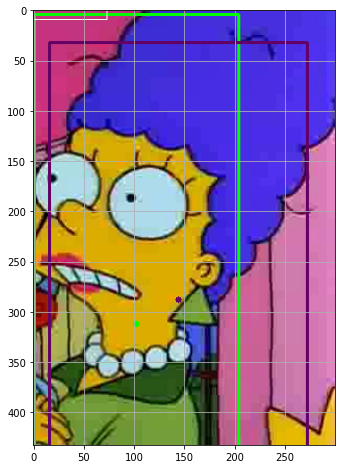

In [ ]:
print("Feature map size  : " + str(Y[0].shape))
print("Shape of y_rpn_classifier : " + str(Y[0].shape))
print("Shape of y_rpn_regressor : " + str(Y[1].shape))
print("Number of positive anchors for this image : %d" % (debug_num_pos))
print('Green bboxes is ground-truth bbox. Others are positive anchors')
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d image_size=%d'%(X.shape[1], X.shape[2], config.image_size))
print('Feature map size: height=%d width=%d RPN_stride=%d'%(Y[0].shape[1], Y[0].shape[2], config.RPN_stride))

if debug_num_pos == 0:
  gx1, gx2 = int(image_data["bboxes"][0]['x1'] * (X.shape[2] / image_data['height'])), int(image_data['bboxes'][0]['x2'] * (X.shape[2] / image_data['height']))
  gy1, gy2 = int(image_data['bboxes'][0]['y1'] * (X.shape[1] / image_data['width'])), int(image_data['bboxes'][0]['y2'] * (X.shape[1] / image_data['width']))

  img = debug_img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  color = (0, 255, 0)
  cv2.putText(img, 'gt bbox', (gx1, gy1 - 5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
  cv2.rectangle(img, (gx1, gy1), (gx2, gy2), color, 2)
  cv2.circle(img, (int((gx1 + gx2) / 2), int((gy1 + gy2) / 2)), 3, color, -1)
  plt.grid()
  plt.imshow(img)
  plt.show()

else:
  rpn_classifier = Y[0][0]
  pos_cls = np.where(rpn_classifier == 1)
  print(pos_cls)

  rpn_regressor = Y[1][0]
  pos_regr = np.where(rpn_regressor == 1)
  print(pos_regr)

  print("y_rpn_classifier for possible pos anchor : {}".format(rpn_classifier[pos_cls[0][0], pos_cls[1][0], :]))
  print("y_rpn_regressor for possible pos anchor : {}".format(rpn_regressor[pos_regr[0][0], pos_regr[1][0], :]))

  gx1, gx2 = int(image_data['bboxes'][0]['x1'] * (X.shape[2] / image_data['height'])), int(image_data['bboxes'][0]['x2'] * (X.shape[2] / image_data['height']))
  gy1, gy2 = int(image_data['bboxes'][0]['y1'] * (X.shape[1] / image_data['width'])), int(image_data['bboxes'][0]['y2'] * (X.shape[1] / image_data['width']))

  img = debug_img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  color = (0, 255, 0)
  cv2.rectangle(img, (gx1, gy1), (gx2, gy2), color, 2)
  cv2.circle(img, (int((gx1 + gx2) / 2), int((gy1 + gy2) / 2)), 3, color, -1)

  (retval, baseLine) = cv2.getTextSize('gt bbox', cv2.FONT_HERSHEY_COMPLEX, 0.5, 1)
  textOrg = (gx1, gy1 + 5)
  cv2.rectangle(img, (textOrg[0] - 5, textOrg[1] + baseLine - 5), (textOrg[0] + retval[0] + 5, textOrg[1] - retval[1] - 5), (255, 255, 255), 1)

  for i in range(debug_num_pos):
    color = (100 + i * (155/4), 0, 100 + i * (155 / 4))
    idx = pos_regr[2][i * 4] / 4
    anchor_scale = config.anchor_scales[int(idx / 3)]
    anchor_ratio = config.anchor_ratios[2 - int((idx + 1) % 3)]

    center = (pos_regr[1][i * 4] * config.RPN_stride, pos_regr[0][i * 4] * config.RPN_stride)
    print("Center position of positive anchor : ", center)
    cv2.circle(img, center, 3, color, -1)
    aw, ah = anchor_scale * anchor_ratio[0], anchor_scale * anchor_ratio[1]
    cv2.rectangle(img, (center[0] - int(aw / 2), center[1] - int(ah / 2)), (center[0] + int(aw / 2), center[1] + int(ah / 2)), color, 2)
    plt.figure(figsize = (8, 8))
  plt.grid()
  plt.imshow(img)
  plt.show()

In [ ]:
img_input = Input(shape=(None, None, 3))
roi_input = Input(shape=(config.num_ROIs, 4))

In [ ]:
shared_layers = ResNet(img_input, trainable= True)
num_anchors = len(config.anchor_ratios) * len(config.anchor_scales)
rpn = RegionProposalNetwork(shared_layers, num_anchors)
fast_rcnn_classifier = FastRCNN(shared_layers, roi_input, config.num_ROIs, nb_classes=len(class_count), trainable = True)

In [ ]:
rpn_model = Model(img_input, rpn[:2])
fast_rcnn_model = Model([img_input, roi_input], fast_rcnn_classifier)
faster_rcnn_model = Model([img_input, roi_input], rpn[:2] + fast_rcnn_classifier)

In [ ]:
rpn_model.compile(optimizer = Adam(lr = 3e-4),
                  loss = [
                          rpn_loss_classifier(num_anchors),
                          rpn_loss_regression(num_anchors)
                         ]
                  )

fast_rcnn_model.compile(optimizer = Adam(lr = 3e-4),
                        loss = [
                                fast_rcnn_loss_classifier,
                                fast_rcnn_loss_regression(len(class_count) - 1)
                                ],
                        metrics = {f'dense_class_{len(class_count)}' : 'accuracy'}
                        )

faster_rcnn_model.compile(optimizer= 'sgd',
                          loss = 'mae')

In [ ]:
steps_per_epoch = 1000
epochs = 1
iteration = 0

best_loss = np.Inf
losses = np.zeros((steps_per_epoch, 5))
rpn_accuracy_monitor, rpn_accuracy_for_epoch = [], []
t0 = start_time = time.time()

In [ ]:
with open('history.csv', 'w') as f:
  f.write('Accuracy,RPN classifier,RPN regression,Fast RCNN classifier,Fast RCNN regression,Total')
  f.write('\t')

In [ ]:
try:
  for epoch in range(1, epochs + 1):
    progress_bar = Progbar(steps_per_epoch)
    print(f'Epoch {epoch}/{epochs}')

    while True:
      try:
        if len(rpn_accuracy_monitor) == steps_per_epoch and config.verbose:
          mean_overlapping_bboxes = float(sum(rpn_accuracy_monitor)) / len(rpn_accuracy_monitor)
          rpn_accuracy_monitor = []
          
          print(f"Average number of overlapping bboxes from RPN = {mean_overlapping_bboxes} for {steps_per_epoch} previous iterations.")
          if mean_overlapping_bboxes == 0:
            print("RPN is not producing bounding boxes that overlaps the ground truth bboxes.\n Check configuration or continue training as it is.")
        
        X, Y, image_data, _, __ = next(datagen_train)

        rpn_loss = rpn_model.train_on_batch(X, Y)
        rpn_pred = rpn_model.predict_on_batch(X)
        try:
          R = from_rpn_to_roi(rpn_pred[0],
                            rpn_pred[1],
                            config,
                            use_reg = True,
                            max_boxes = 300,
                            overlap_threshold = 0.7)
          
          print(f'from_rpn_to_roi() output -> R : {R.shape}')
          print(R)
        except Exception as e:
          print("Some Error in the function from_rpn_to_roi()")
          print(e)
          break

        try:        
          X2, Y1, Y2, debug_iou = calculate_iou(R,
                                     image_data,
                                     config,
                                     class_mapping)
          print(f'calculate_iou() output -> X2.shape : {X2.shape}')
          print(f'calculate_iou() output -> Y1.shape : {Y1.shape}')
          print(f'calculate_iou() output -> Y2.shape : {Y2.shape}')
          print(f'calculate_iou() output -> X2: {X2}')
          print(f'calculate_iou() output -> Y1: {Y1}')
          print(f'calculate_iou() output -> Y2: {Y2}')
        except Exception as e:
          print("Some Error in the function calculate_iou()")
          print(e)
          break

        if X2 is None:
                rpn_accuracy_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
        
        negative_samples = np.where(Y1[0, :, -1] == 1)
        positive_samples = np.where(Y1[0, :, -1] == 0)
        negative_samples = negative_samples[0] if len(negative_samples) > 0 else []
        positive_samples = positive_samples[0] if len(positive_samples) > 0 else []

        rpn_accuracy_monitor.append(len(positive_samples))
        rpn_accuracy_for_epoch.append((len(positive_samples)))

        if config.num_ROIs > 1:
          selected_pos_samples = positive_samples.tolist() if len(positive_samples) < config.num_ROIs//2 else np.random.choice(positive_samples, config.num_ROIs//2, replace = False).tolist()
          try:
            selected_neg_samples = np.random.choice(negative_samples, config.num_ROIs - len(selected_pos_samples), replace= False).tolist()
          except Exception as e:
            selected_neg_samples = np.random.choice(negative_samples, config.num_ROIs - len(selected_pos_samples), replace= True).tolist()

          selected_samples = selected_pos_samples + selected_neg_samples
        else:
          selected_pos_samples = positive_samples.tolist()
          selected_neg_samples = negative_samples.tolist()
          selected_samples = random.choice(negative_samples) if np.random.randint(0, 2) else random.choice(positive_samples)

        print("Selected Samples : " + str(selected_samples))
        
        print("Block 4")
        fast_rcnn_loss = fast_rcnn_model.train_on_batch([X, X2[:, selected_samples, :]], [Y1[:, selected_samples, :], Y2[:, selected_samples, :]])
        print("Fast RCNN Loss : " + fast_rcnn_loss)

        losses[iteration, 0] = rpn_loss[1]
        losses[iteration, 1] = rpn_loss[2]
        losses[iteration, 2] = fast_rcnn_loss[1]
        losses[iteration, 3] = fast_rcnn_loss[2]
        losses[iteration, 4] = fast_rcnn_loss[3]

        iteration += 1

        progress_bar.update(iteration,
                            [
                             ('rpn_cls', np.mean(losses[:iteration, 0])),
                             ('rpn_regr', np.mean(losses[:iteration, 1])),
                             ('fast_rcnn_cls', np.mean(losses[:iteration, 2])),
                             ('fast_rcnn_regr', np.mean(losses[:iteration, 3]))
                            ])
        
        print("Block 5")
        if iteration == steps_per_epoch:
          loss_rpn_cls = np.mean(losses[:, 0])
          loss_rpn_regr = np.mean(losses[:, 1])
          loss_fast_rcnn_cls = np.mean(losses[:, 2])
          loss_fast_rcnn_regr = np.mean(losses[:, 3])
          fast_rcnn_accuracy = np.mean(losses[:, 4])

          mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
          rpn_accuracy_for_epoch = []

          if config.verbose:
            print(f'Mean number of bboxes from RPN overlapping with ground truth boxes : {mean_overlapping_bboxes}')
            print(f'Classifier accuracy for bboxes from RPN : {fast_rcnn_accuracy}')
            print(f'Loss RPN classifier : {loss_rpn_cls}')
            print(f'Loss RPN regression : {loss_rpn_regr}')
            print(f'Loss FRCNN classifier : {loss_fast_rcnn_cls}')
            print(f'Loss FRCNN regression : {loss_fast_rcnn_regr}')
            print(f'Elapsed time : {time.time() - start_time}')

          current_loss = loss_rpn_cls + loss_rpn_regr + loss_fast_rcnn_cls + loss_fast_rcnn_regr
          history_record = open('history.csv', 'a')
          history_record.write(f'{fast_rcnn_accuracy},{loss_rpn_cls},{loss_rpn_regr},{loss_fast_rcnn_cls},{loss_fast_rcnn_regr},{total_loss}')
          history_record.write('\t')

          iteration = 0
          start_time = time.time()

          if current_loss < best_loss:
            if config.verbose:
              print(f'Total loss decreases from {best_loss} to {current_loss}, saving weights.')
            best_loss = current_loss
            faster_rcnn_model.save_weights(config.model_path)
          break

        break        
      except Exception as e:
        print(e)
        break

except KeyboardInterrupt:
  t1 = time.time()
  print(f'\nIt took : {t1 - t0}s')

Epoch 1/1
from_rpn_to_roi() output -> R : (300, 4)
[[ 1  0 18 23]
 [11  0 18 22]
 [12  0 18 15]
 ...
 [ 0 20  6 24]
 [10  4 18 12]
 [ 3 22 11 26]]
calculate_iou() output -> X2.shape : (1, 97, 4)
calculate_iou() output -> Y1.shape : (1, 97, 19)
calculate_iou() output -> Y2.shape : (1, 97, 144)
calculate_iou() output -> X2: [[[ 1  0 17 23]
  [ 0  0 11 26]
  [ 5  0 13 26]
  [ 2  0 14 18]
  [ 5  0 13 16]
  [ 0  0 14 22]
  [ 0 15  8  8]
  [ 0 10 15  8]
  [ 0  4  8  8]
  [ 0  2  8  8]
  [ 0  0 13 12]
  [ 0  0 15 15]
  [ 0  0 10 10]
  [ 0  7 18 16]
  [ 0  7 12  8]
  [ 0  7  8  8]
  [ 3  0 11 13]
  [ 1 10 16 16]
  [ 3  0 15  8]
  [ 0 11  8  8]
  [ 0  0  8  6]
  [ 0  9  8  8]
  [ 2  2 16  8]
  [ 0  6 10  8]
  [ 0  3  9  8]
  [ 0  4 18 16]
  [ 1 11 16  8]
  [ 0 16  9  8]
  [ 0 10 10 16]
  [ 0 11 12  8]
  [ 0 13  8  8]
  [ 0 12  9  8]
  [ 4  7 14 19]
  [ 2 15 16  8]
  [ 2  5 16  8]
  [ 0  9 13  8]
  [ 0  8  9  8]
  [ 0  6 14 20]
  [ 0 10 10  8]
  [ 0  2 12  8]
  [ 0 15 14  8]
  [ 0  0  7  9]
  [ 